# Assignment 3

Matrikelnr.: 2089929

## Imports

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

## Überblick und Vorbereitung der Daten

In [75]:
df_social = pd.read_csv('03_Clustering_Marketing.csv',delimiter=';')

Der Datensatz umfasst 15.000 Zeilen und 40 Spalten. Er enthält eine Mischung aus numerischen und kategorialen Variablen, darunter das Abschlussjahr (gradyear), Geschlecht (gender), Alter (age), die Anzahl der Freunde (NumberOffriends) sowie eine Vielzahl von Angaben zu Interessen und Aktivitäten wie Basketball, Fußball, Schwimmen und persönliche Vorlieben wie Musik und Einkaufen.

Die Abschlussjahre im Datensatz reichen von 2006 bis 2009. Das Alter der Personen variiert, wobei einige Werte fehlen. Die Anzahl der Freunde pro Person reicht von 0 bis 605, mit einem Durchschnittswert von etwa 30 Freunden. Neben diesen demografischen Informationen enthält der Datensatz Angaben zu verschiedenen Aktivitäten und Vorlieben in Form von booleschen Werten.

### Datentypen berichtigen

In [76]:
df_social['age'] = pd.to_numeric(df_social['age'], errors='coerce')

### Nullwerte entfernen

In [77]:
df_social = df_social.dropna()

### Feature Extraction

<Axes: xlabel='age', ylabel='Count'>

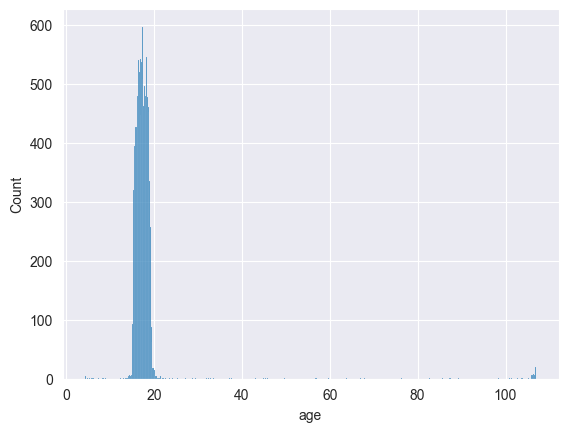

In [78]:
sns.histplot(df_social['age'])

Durch die Verwendung von float als Datentyp der Spalte Alter sehen wir extrem viele Dimensionen. Aus diesem Grund reduzieren wir die Dimensionen, indem wir Altersklassen definieren und in Bins zusammenfassen. Wir sehen außerdem eine Häufung im Altersbereich von 10 bis 20 Jahren. Deshalb definieren wir die Bins hier etwas feiner.

<Axes: xlabel='age', ylabel='Count'>

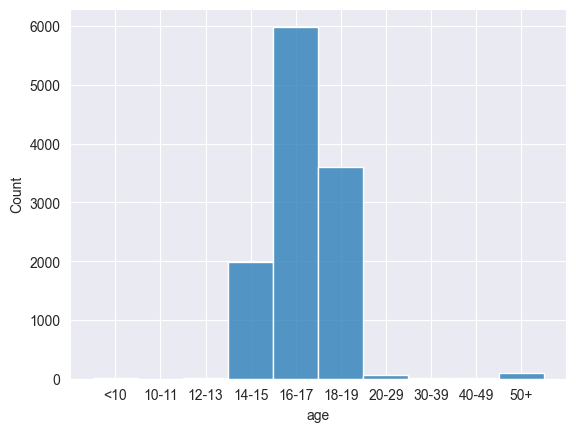

In [79]:
# Altersklassen definieren
bins = [0, 10, 12, 14, 16, 18, 20, 30, 40, 50, np.inf]
labels = ['<10', '10-11', '12-13', '14-15', '16-17', '18-19', '20-29', '30-39', '40-49', '50+']

# Bins erstellen
df_social['age'] = pd.cut(df_social['age'], bins=bins, labels=labels, right=False)
sns.histplot(df_social['age'])

<Axes: xlabel='NumberOffriends', ylabel='Count'>

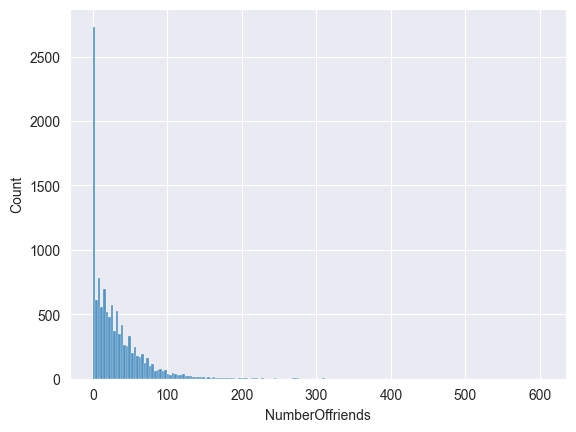

In [80]:
sns.histplot(df_social['NumberOffriends'])

Eine ähnliche Problematik sehen wir auch bei der Anzahl der Freunden, weshalb wir hier auch eine Dimensionsreduktion durchführen.

In [81]:
# Bins definieren für Anzahl an Freunden
bins_friends = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
labels_friends = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100','100+']

# Bins erstellen
df_social['NumberOffriends'] = pd.cut(df_social['NumberOffriends'], bins=bins_friends, labels=labels_friends, right=False)

<Axes: xlabel='NumberOffriends', ylabel='Count'>

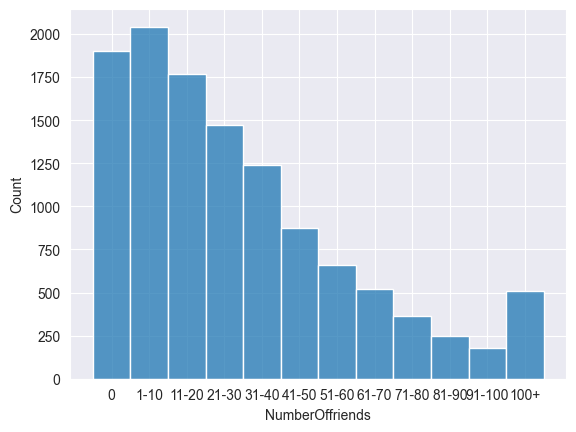

In [82]:
sns.histplot(df_social['NumberOffriends'])

### Prüfen von Ungleichgewichten

<Axes: xlabel='gender', ylabel='Count'>

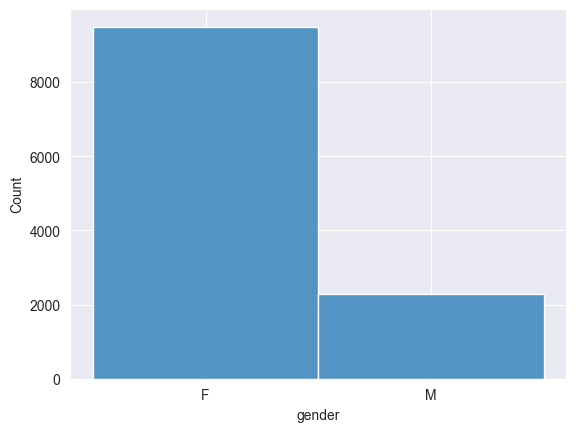

In [83]:
sns.histplot(df_social['gender'])

Wir sehen ein starkes Ungleichgewicht in Richtung des weiblichen Geschlechts, diesem werden wir uns später widmen.

In [84]:
# Dataframe aufteilen nach Geschlecht
df_social_m = df_social[df_social['gender'] == 'M']
df_social_f = df_social[df_social['gender'] == 'F']

# Die unterrepräsentierte Klasse identifizieren
undersample_size = min(len(df_social_m), len(df_social_f))

# Beide Dataframes nach der Größe der kleineren Klasse resamplen
df_social_m_under = df_social_m.sample(undersample_size, random_state=42)
df_social_f_under = df_social_f.sample(undersample_size, random_state=42)

# Beide Dataframes wieder kombinieren
df_social = pd.concat([df_social_m_under, df_social_f_under])

<Axes: xlabel='gender', ylabel='Count'>

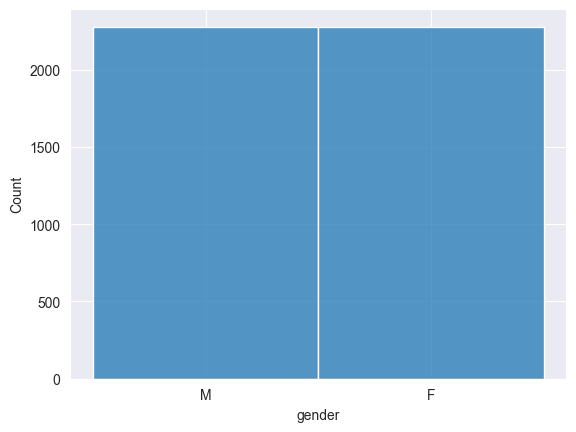

In [85]:
sns.histplot(df_social['gender'])

### Encoding

In [86]:
# Nicht-numerische Spalten identifizieren
non_numeric_columns = df_social.select_dtypes(include=['object', 'category']).columns

# Alle nicht-numerischen Spalten encoden
for col in non_numeric_columns:
    unique_values = df_social[col].unique()
    df_social[col] = df_social[col].replace(to_replace=unique_values, value=list(range(len(unique_values))))
    
df_social.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
2700,2008,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9093,2007,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12531,2009,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10337,2006,0,1,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9518,2009,0,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Aufgabe 01
Cluster the existing data based on appropriate procedures. Justify how you would cluster the data set based on the results.

Zuerst führen wir die Ellenbogen-Methode durch, um eine Idee für die Anzahl an Clustern zu bekommen.

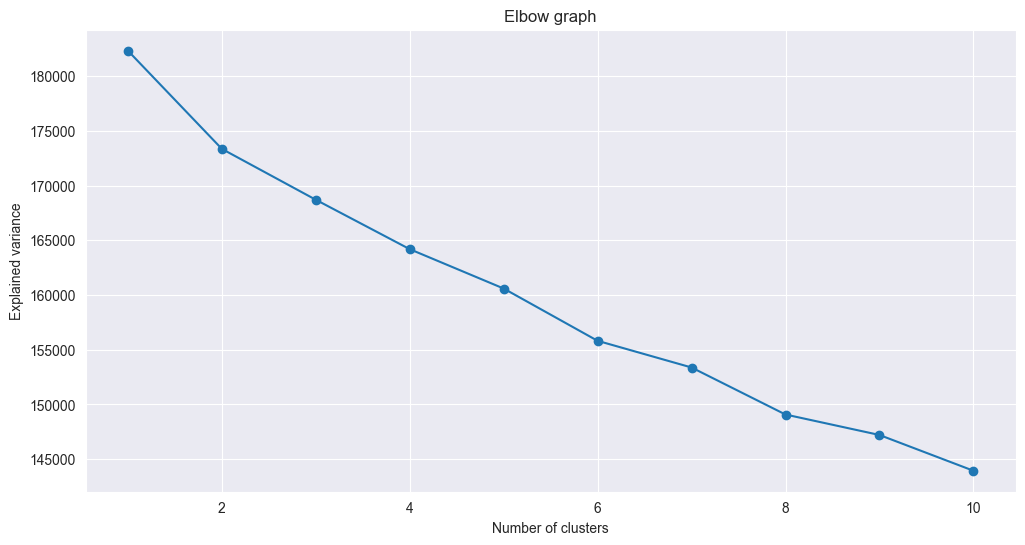

In [87]:
from sklearn.cluster import KMeans

# Preprocess the data for KMeans clustering
df_cluster = StandardScaler().fit_transform(df_social)  # Normalize the data

explained_variances = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_cluster)
    explained_variances.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 11), explained_variances, 'o-')
plt.title('Elbow graph')
plt.xlabel('Number of clusters')
plt.ylabel('Explained variance')
plt.show()

Des Weiteren wenden wir noch die Silhouette Methode an.

Best silhouette score: 0.4001137589464833 for n_clusters: 2


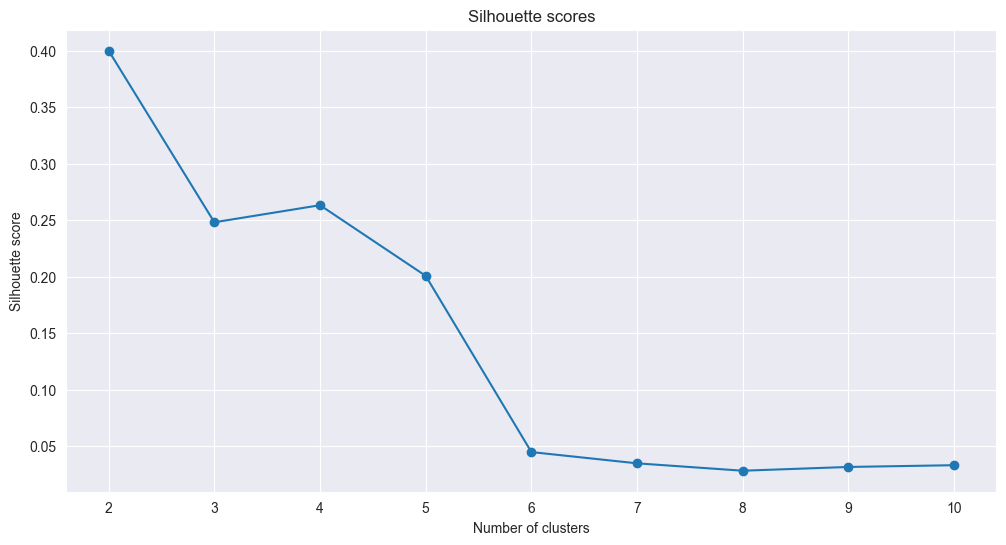

In [88]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for i in range(2, 11):  # Starts from 2 clusters because silhouette_score cannot be calculated with only 1 cluster
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_cluster)
    score = silhouette_score(df_cluster, kmeans.labels_)
    silhouette_scores.append((i, score))

# Get the number of clusters and silhouette score of the best result
best_result = max(silhouette_scores, key=lambda x:x[1])
print(f"Best silhouette score: {best_result[1]} for n_clusters: {best_result[0]}")

# Plot Silhouette scores
plt.figure(figsize=(12, 6))
plt.plot([x[0] for x in silhouette_scores], [x[1] for x in silhouette_scores], 'o-')
plt.title('Silhouette scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

Sowohl die Ellenbogen- als auch die Silhouette Methode haben eine optimale Clusterzahl von k=2 aufgezeigt. Mit dieser Clusterzahl können wir jetzt k-means anwenden.

In [89]:
# Create the KMeans model
kmeans_model = KMeans(n_clusters=2, random_state=0)

# Fit the model to the data and predict the cluster assignments for each data point
df_social['cluster'] = kmeans_model.fit_predict(df_social)

# Print out the results
print(df_social['cluster'].value_counts())

cluster
1    3477
0    1081
Name: count, dtype: int64


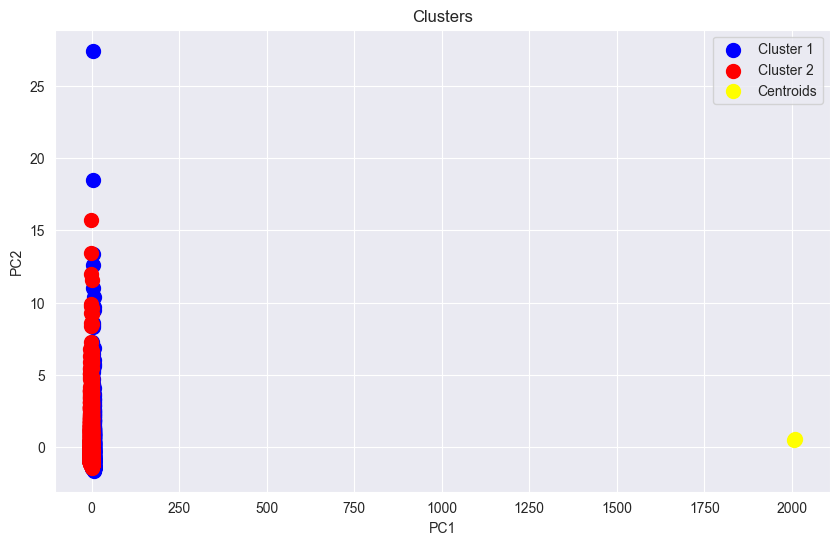